In [3]:
%matplotlib notebook

# General imports
import os, json, cmath, math, sys, traceback, copy, treelib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import optimize, signal, interpolate, integrate, stats
from matplotlib.ticker import FormatStrFormatter

# Peak finding using Ricker wavelets

`scipy.signal.find_peaks_cwt` works in the following way: It calculates a wavelet transform matrix for the signal using some wavelet of choice. Any peaks will show up in the matrix as local maxima. These local maxima will follow some path as the wavelet dilation is increased or decreased. These paths are called 'ridge lines'. The algorithm will pick out local maxima whose ridge lines satisfy certain conditions. 

Ricker wavelets are commonly used for peak detection using the wavelet transform. These wavelets are simply the second derivative of a Gaussian which makes them Gaussian-like in shape. The main difference is the two negative-valued dips on either side of the main central peak. These dips actually help differentiate overlapping peaks. When the wavelet is centered on any local minimum in the signal, the dips of the wavelet will be located at positions in the curve where the signal amplitude is larger than the signal amplitude located where the central peak sits; this is by definition a local minimum. Therefore, the integral of the product of the signal and the wavelet will experience a decrease in value because the negative dips will contribute more "negative area". Contrast this to when the wavelet is centered on a local minimum. The signal amplitude at the locations of the dips will be less than the signal amplitude where the wavelet peak is centered. Therefore, the amount of "negative area" contributed to the product integral will be less and the value of the transform will remain high. 

Shown below is an example of the wavelet transform matrix plotted as a pcolormesh. The x-axis corresponds to the offset of the wavelet and y-axis is the width or dilation of the wavelet. We can see one large ridge line corresponding to a peak that gets more focused as the width decreases or resolution increases. 

![Ridge lines](img/cwt_ridgelines.png)

In [1]:
def multiple_gaussian(x, *params):
    """ Multiple Gaussians function

    Args:
        x: Numpy array of x-data to be used in fitting or plotting
        params*: List of fitting parameters in the following order:
        [y-offset, gaussian1 center, gaussian1 amplitude, gaussian1 stdev, gaussian2 center, gaussian2 amplitude, ...]

    Returns:
        Numpy array of Gaussian y-data calculated from input x-data and parameters

    """
    
    y = np.zeros_like(x)
    for i in range(1, len(params), 3):
        ctr = params[i]
        amp = params[i+1]
        wid = params[i+2]
        y = y + amp * np.exp( -0.5*((x - ctr)/wid)**2)
    return y + params[0]

def ricker_wavelet(x, **kwargs):
    """ Returns a Ricker wavelet evaluated at the x positions provided. 

    Args:
        x: Numpy array of x-data
        **kwargs:
            'width': The width of the Ricker wavelet. Must be >= 0. 
            'center': Center position of the wavelet. 

    Returns:
        Numpy array representing the Ricker wavelet evaluated at the provided x positions

    """
    w = kwargs['width']
    c = kwargs['center']
    return 2/(math.sqrt(3*w)*(math.pi**0.25)) * (1 - ((x-c)/w)**2) * np.exp(-0.5*((x-c)/w)**2)

def ricker_wavelettransform(x, y, **kwargs):
    """ Returns the L2 inner product between a Ricker wavelet and the provided real signal over the given
    signal domain.

    Args:
        x: Numpy array of x-data of the signal
        y: Numpy array of y-data of the signal
        **kwargs:
            'width': The width of the Ricker wavelet. Must be >= 0. 
            'center': Center position of the wavelet. 

    Returns:
        Scalar value corresponding to the L2 inner product between the Ricker wavelet and the real signal
        over the given signal domain

    """
    return integrate.trapezoid(ricker_wavelet(x, **kwargs)*y, x)
    
def ricker_wavelet_mesh(x, y, **kwargs):
    """ Returns wavelet transform evaluated on a meshgrid formed from a range of widths and center positions

    Args:
        x: Numpy array of x-data of the signal
        y: Numpy array of y-data of the signal
        **kwargs:
            'widths': The range of widths of the Ricker wavelet. Must be >= 0. 
            'centers': The range of center positions of the wavelet. 

    Returns:
        Tuple of:
        Numpy sparse grid of widths, 
        Numpy sparse grid of center position, 
        2D Numpy array of wavelet transform evaluated on the mesh grid formed from previous 2 grids

    """
    c_mesh, w_mesh = np.meshgrid(kwargs['centers'], kwargs['widths'], sparse = True)
    return w_mesh, c_mesh, np.vectorize(lambda w, c: ricker_wavelettransform(x, y, width = w, center = c), 
                                        otypes = ['float'])(w_mesh, c_mesh)

def ricker_peak_finder(x, y, **kwargs):
    widths = kwargs['widths']
    centers = kwargs['centers']
    width_skip = kwargs['width_skip'] if 'width_skip' in kwargs else 1
    ridge_thresh = kwargs['ridge_thresh']
    total_thresh = kwargs['total_thresh']
    
    maxima_sep = kwargs['maxima_sep'] if 'maxima_sep' in kwargs else widths / 2
    if type(maxima_sep) is float or type(maxima_sep) is int:
        maxima_sep = np.repeat(maxima_sep, len(widths))
        
    maxima_thresh = kwargs['maxima_thresh']
    if type(maxima_thresh) is float or type(maxima_thresh) is int:
        maxima_thresh = np.repeat(maxima_thresh, len(widths))
    
    # Find the wavelet transform for the given widths and center positions
    w_mesh, c_mesh, transform = ricker_wavelet_mesh(x, y, widths = widths, centers = centers)
    
    # Find the indices of the local maxima at each width scale
    maxima = []
    for w_index in range(transform.shape[0]):
        maxima.append(signal.argrelextrema(transform[w_index,:], 
                                           comparator = lambda a1, a2: np.logical_and(a1 > maxima_thresh[w_index], np.greater(a1, a2)), 
                                           order = 2)[0])
    
    # Represent ridges as nodes in a tree
    tree = treelib.Tree()
    root = tree.create_node(tag = 'root', identifier = 'root')
    
    # Initialize the first level of ridges using the local maxima found at the largest width scale
    for m_index in maxima[0]:
        tree.create_node(identifier = '0,{0}'.format(m_index), 
                         parent = 'root', 
                         data = [np.array([0]), np.array([m_index])])
    
    # Loop through each subsequent width scale and add the local maxima to an existing ridge or 
    # create a new ridge if the local maxima is separated far enough from other maxima
    for w_index in range(1, len(maxima)):
        w_maxima = maxima[w_index]
        
        # Compile list of potential parent ridges by ID for each of the current maxima
        parents = []
        for m_index in w_maxima:
            potential_parents = []
            for ridge in tree.all_nodes():
                if not ridge.is_root():
                    in_range = abs(centers[m_index] - centers[ridge.data[1][-1]]) < maxima_sep[w_index]
                    in_skip = abs(w_index - ridge.data[0][-1]) <= width_skip
                    if in_range and in_skip:
                        potential_parents.append(ridge.identifier)
            parents.append(potential_parents)
            
        # Go over list of possible parents and create new nodes accordingly
        for i, potential_parents in enumerate(parents):
            if len(potential_parents) == 0:
                tree.create_node(identifier = '{0},{1}'.format(w_index, w_maxima[i]), 
                                 parent = 'root', 
                                 data = [np.array([w_index]), np.array([w_maxima[i]])])
            
            if len(potential_parents) == 1:
                tree.create_node(identifier = '{0},{1}'.format(w_index, w_maxima[i]), 
                                 parent = potential_parents[0], 
                                 data = [np.array([w_index]), np.array([w_maxima[i]])])
        
        # Prune tree by removing any single child nodes and merging the child data with the parent data
        has_onechild = list(tree.filter_nodes(lambda ridge: not ridge.is_root() and len(tree.children(ridge.identifier)) == 1))
        for ridge in has_onechild:
            child = tree.children(ridge.identifier)[0]
            ridge.data[0] = np.append(ridge.data[0], child.data[0])
            ridge.data[1] = np.append(ridge.data[1], child.data[1])
            tree.remove_node(child.identifier)
        
    # Now check if the ridges meet the criteria for peak detection
    peak_indices = []
    ridges = []
    for ridge in tree.all_nodes():
        if not ridge.is_root():
            # Check if sum of transform of all points in the ridge passes the threshold
            ridge_sum = np.sum(transform[ridge.data[0], ridge.data[1]])
            
            # Starting from current ridge, move up tree and add the sums of all ancestor ridges encountered
            total_sum = ridge_sum
            parent = tree.parent(ridge.identifier)
            while not parent.is_root():
                print(parent.identifier)
                total_sum += np.sum(transform[parent.data[0], parent.data[1]])
                parent = tree.parent(parent.identifier)
                
            # Check if all child ridges fail the threshold
            small_children = True
            for chlid in tree.children(ridge.identifier):
                if np.sum(transform[child.data[0], child.data[1]]) > ridge_thresh:
                    small_children = False
                    break
                    
            # Add information of the ridge to the list
            ridges.append({
                'centers': centers[ridge.data[1]],
                'widths': widths[ridge.data[0]],
                'ridge_sum': ridge_sum,
                'total_sum': total_sum
            })
            
            # A ridge is considered to be a peak if it passes the following criteria
            if ridge_sum > ridge_thresh and total_sum > total_thresh and small_children:
                peak_indices.append(ridge.data[1][-1])
                
    # CHANGE THIS TO A NAMED TUPLE INSTEAD
    return {
        'w_mesh': w_mesh,
        'c_mesh': c_mesh,
        'transform': transform,
        'locations': centers[peak_indices],
        'ridges': ridges
    }

<IPython.core.display.Javascript object>


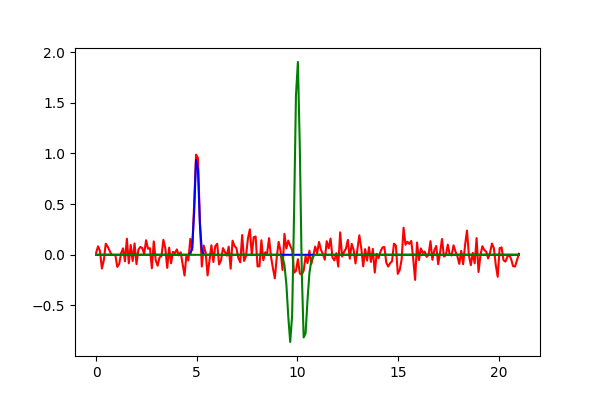

In [6]:
%matplotlib notebook

x = np.linspace(0, 21, num = 221)

#y = multiple_gaussian(x, *[0, 2, 2, .3, 2.6, 1.5, .25, 5, 10, .8, 11, 4, 1.7, 15, .5, .08, 18, 1, 0.7, 7, 1, .3])
y = multiple_gaussian(x, *[0, 5, 1, .1])

noise = np.random.normal(0, .2, size = 221)

fig, ax = plt.subplots(figsize = (6, 4))

ax.plot(x, y+0.5*noise, color = 'red')

ax.plot(x, y, color = 'blue')

ax.plot(x, ricker_wavelet(x, center = 10, width = 0.2), color = 'green')

plt.show()

Start: 1.8, 4.99
End: 0.2, 4.99
Length = 9
Rsum = 2.092114631061576
Total = 2.092114631061576
Initial T = [[0.16129021]]


[4.99]


<IPython.core.display.Javascript object>


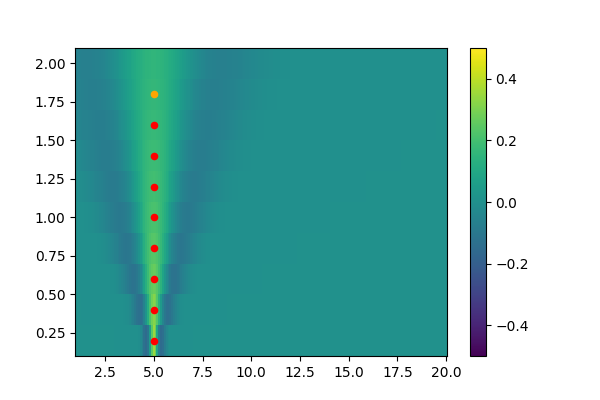

In [7]:
f = lambda w, a: (2*math.sqrt(2*math.pi)/(math.pi**0.25*3**0.5))*math.sqrt(a/(1+a**2))*np.sqrt(w)*(1-0.5/(1+a**2))

w = np.linspace(2, .2, num = 10)
c = np.linspace(1, 20, num = 201)

result = ricker_peak_finder(x, y, 
                      widths = w, 
                      centers = c, 
                      maxima_thresh = 0.1*f(w, 1), 
                      ridge_thresh = .05, 
                      total_thresh = .05
                     )

c_mesh = result['c_mesh']
w_mesh = result['w_mesh']
transform = result['transform']
ridges = result['ridges']

for ridge in ridges:
    print('Start: {0}, {1}\nEnd: {2}, {3}\nLength = {4}\nRsum = {5}\nTotal = {6}\nInitial T = {7}'.format(ridge['widths'][0], 
                                                                                                          ridge['centers'][0], 
                                                                                                          ridge['widths'][-1], 
                                                                                                          ridge['centers'][-1], 
                                                                                                          len(ridge['centers']), 
                                                                                                          ridge['ridge_sum'], 
                                                                                                          ridge['total_sum'], 
                                                                                                          transform[np.where(w == ridge['widths'][0]), np.where(c == ridge['centers'][0])]))
    print('\n')

print(result['locations'])

fig, ax = plt.subplots(figsize = (6, 4))

pmesh = ax.pcolormesh(c_mesh,
                      w_mesh, 
                      transform,
                      shading = 'auto', 
                      vmin = -.5,
                      vmax = .5,
                      cmap = plt.get_cmap('viridis'))

for ridge in ridges:
    for index, val in enumerate(ridge['centers']):
        ax.scatter(val, ridge['widths'][index], s = 20, color = 'red' if index != 0 else 'orange')

cbar = plt.colorbar(pmesh, orientation = 'vertical')


plt.show()

0.2


<IPython.core.display.Javascript object>


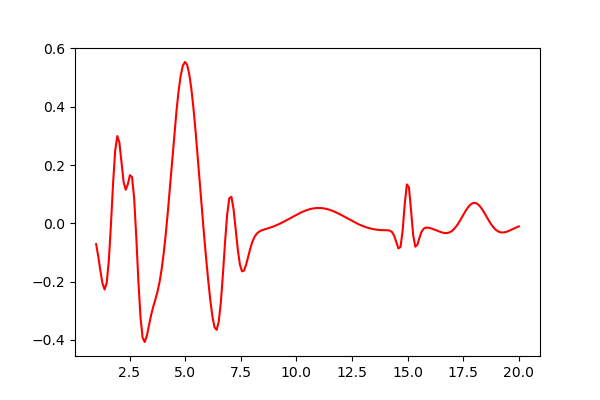

In [11]:
slice_index = 9

print(w[slice_index])

fig2, ax2 = plt.subplots(figsize = (6, 4))

ax2.plot(c, transform[slice_index, :], color = 'red')

plt.show()

<IPython.core.display.Javascript object>


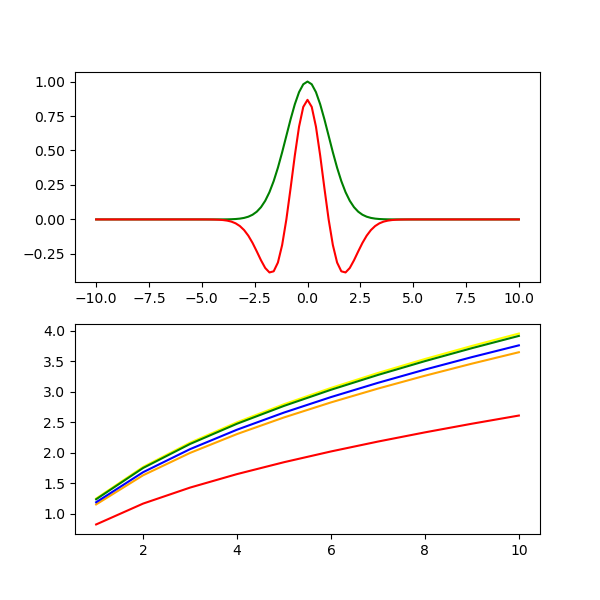

In [15]:
f = lambda w, a: (2*math.sqrt(2*math.pi)/(math.pi**0.25*3**0.5))*math.sqrt(a/(1+a**2))*np.sqrt(w)*(1-0.5/(1+a**2))

x = np.linspace(-10, 10, num = 101)

width = 1

y = multiple_gaussian(x, *[0, 0, 1, width])

w = np.linspace(10, 1, num = 10)

ts = [ricker_wavelettransform(x, multiple_gaussian(x, *[0, 0, 1, s]), width = s, center = 0) for s in w]


fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (6, 6))

ax[0].plot(x, y, color = 'green')
ax[0].plot(x, ricker_wavelet(x, width = width, center = 0), color = 'red')

colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']

for a in range(1,len(colors)):
    ax[1].plot(w, f(w, a*.5), color = colors[a-1])

#ax.plot(w, 2*math.pi**0.25/(np.sqrt(3*w))*(w - 0.5*(1/w**3)), color = 'red')

#ax.plot(x, y, color = 'red')

#ax.plot(x, ricker_wavelet(x, width = .5, center = 0), color = 'blue')

plt.show()

# Here begins random garbage stuff

# Multiple File Plotting (Uses glob)

In [ ]:
%matplotlib notebook

import numpy as np
import traceback, sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import optimize, signal, interpolate
import cmath, math, glob, os

#directory
data_dir = "C:/algos/jupyter-notebooks/data/2021-04-23_12nm Nb_5nm Au_10nm Te_pt contact/Transport_inplane field"

#load data
data = []
os.chdir(data_dir)
files = glob.glob('*[0-9]K.txt')

for file in files:
    data.append(np.genfromtxt(file, delimiter="\t", dtype=float))

num_plots = len(data)


#build rainbow cmap for legend
plot_cm = plt.cm.gist_rainbow(np.linspace(0, 1, num_plots))

fig, ax = plt.subplots(figsize=(4, 3))
plt.subplots_adjust(left = 0.2 ,bottom = 0.2)   

for i in range(num_plots):
    zorder = i
    if i is 0:
        zorder = 20
    ax.plot(data[i][:, 0], data[i][:, 1], color = plot_cm[i], zorder = zorder)

ax.set_xlabel('Field (T)')
ax.set_ylabel('Resistance (Ohms)')
ax.legend(['0.3K','1.1K', '2K', '3K', '4K', '5K', '6K', '7K', '8K'], prop={'size': 8})

plt.show()

#save img
os.chdir('C:/algos/jupyter-notebooks')
plt.savefig('./plt_img/2021-04-23_RvsH_12nm Nb_5nm Au_300mK-8K.png')

# Scatter Plot

In [ ]:
%matplotlib notebook

import numpy as np
import traceback, sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import optimize, signal, interpolate
import cmath, math, os

#single file path
fdir = r"C:\algos\jupyter-notebooks\data\2022-02-15_EuS"
fname = "2022-02-15_FermiDiracFitvsdV.txt"
fpath = os.path.join(os.path.normpath(fdir.replace(os.sep, '/')), fname)

data = np.genfromtxt(fpath, delimiter="\t", dtype=float, skip_header = 1)

fig, ax = plt.subplots(figsize = (8,5))
#ax.tick_params(axis = 'both', which = 'both', bottom = False, left = True, labelleft = True, labelbottom = False)


fields = np.array([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.08])
#pos = np.array([0.483, .4, .4, .346, .32, .266, .226, .193])
pos = np.array([16.528621851207284,
15.096817681930348,
14.663736132888337,
13.350599176138642,
12.021149959056656,
10.242575816012433,
8.79154648277244,
8.26100365963517])

data = np.vstack((fields, pos)).T

ax.scatter(data[:, 0], data[:, 1], c = 'red')

#ax.set_xticks(np.linspace(-.05, .05, num = 5))
#ax.set_xlim([-.05, .05])
ax.set_xlabel(r'Field (T)')

def applyToActual(x):
    return x*0.0023125*.78*1000

def actualToApply(x):
    return x / (0.0023125*.78*1000)

ax.set_ylabel(r'Peak Height ($2e^2/h$)')

#secax = ax.secondary_xaxis(location = 'top', functions = (actualToApply, applyToActual))
#secax.set_xlabel('Lock-in Applied dV (mV)')

for i, val in enumerate(data[:, 1]):
    ax.annotate(r'{:.2f}'.format(data[i, 1]), (data[i, 0], data[i, 1]), xytext = (-10, 8), textcoords = 'offset points',
               fontsize = 'x-small')

plt.subplots_adjust(left = 0.25) 
plt.show()

plt.savefig('./plt_img/2022-02-15_dIdV_zerobiaspeakheight_0T-0.08T.png', transparent = True)

# Gradient Curve Plot

In [ ]:
%matplotlib notebook

import numpy as np
import traceback, sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.collections import LineCollection
from scipy import optimize, signal, interpolate
import cmath, math, os

t = 1
u = 1*t
b = 0.7
d = 1


def band(x, sign):
    return math.sqrt(b**2 + d**2 + (x**2 - u)**2 + (u*x)**2 + 
                     2*sign * math.sqrt(b**2*d**2 + b**2 * (x**2 - u)**2 + (u*x)**2*(x**2-u)**2))

'''
def band(x, sign):
    return x**2 - u + sign*math.sqrt(4*x**2 + b**2)
'''

xdata = np.linspace(-math.pi, math.pi, num = 301)
ydata = np.array([band(x, 1) for x in xdata])
ydata2 = np.array([band(x, -1) for x in xdata])
ydata3 = u - ydata
ydata4 = u - ydata2

ydata_pts = np.array([xdata, ydata +1.2]).T.reshape(-1, 1, 2)
ydata_segments = np.concatenate([ydata_pts[:-1], ydata_pts[1:]], axis = 1)

norm = plt.Normalize(-math.pi+.5, math.pi-.5)
lc= LineCollection(ydata_segments, cmap = 'seismic', norm = norm)
lc.set_array(xdata)
lc.set_linewidth(2)


ydata_pts2 = np.array([xdata, ydata2 +1.2]).T.reshape(-1, 1, 2)
ydata_segments2 = np.concatenate([ydata_pts2[:-1], ydata_pts2[1:]], axis = 1)

lc2= LineCollection(ydata_segments2, cmap = 'seismic', norm = norm)
lc2.set_array(xdata)
lc2.set_linewidth(2)

ydata_pts3 = np.array([xdata, ydata3]).T.reshape(-1, 1, 2)
ydata_segments3 = np.concatenate([ydata_pts3[:-1], ydata_pts3[1:]], axis = 1)

lc3= LineCollection(ydata_segments3, cmap = 'seismic', norm = norm)
lc3.set_array(xdata)
lc3.set_linewidth(2)


ydata_pts4 = np.array([xdata, ydata4]).T.reshape(-1, 1, 2)
ydata_segments4 = np.concatenate([ydata_pts4[:-1], ydata_pts4[1:]], axis = 1)

lc4= LineCollection(ydata_segments4, cmap = 'seismic', norm = norm)
lc4.set_array(xdata)
lc4.set_linewidth(2)


fig, ax = plt.subplots(figsize = (4,4))
plt.subplots_adjust(hspace = 0, bottom = 0.2, left = 0.2)

line1 = ax.add_collection(lc)
line2 = ax.add_collection(lc2)
line3 = ax.add_collection(lc3)
line4 = ax.add_collection(lc4)

ax.plot([-math.pi, math.pi], [1.2, 1.2],color = 'black',linestyle = '--')

#curve1 = ax.plot(xdata, ydata + 2.2, color = 'blue')
#curve2 = ax.plot(xdata, ydata2 + 2.2, color = 'red')
#curv2 = ax.plot([.25, .25], [0, 1.2], color = 'red', linestyle = '--')
#curv3 = ax.plot(xdata, ydata2, color = 'green')

#ax.scatter(m, alpha*m**2 + beta / 2 *m**4, color = 'red')
#ax.scatter(-m, alpha*m**2 + beta / 2 *m**4, color = 'red')

ax.tick_params(axis = 'both', which = 'both', bottom = False, left = False, labelleft = False, labelbottom = False)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
#ax.set_xlabel(r'$E$', fontsize = 20, labelpad = 0)
#ax.xaxis.set_label_coords(1, -.05)
#ax.set_ylabel(r'$D_s(E)$', fontsize = 15, rotation = 0, labelpad = 25)
ax.set_ylim([-4, 6])
ax.set_xlim([-math.pi - .5, math.pi +.5])
#ax.set_xticks([-math.pi, 0, math.pi])
#ax.set_xticklabels([r'$\Delta$'], fontsize = 15)
#ax.set_yticks([0, .5, 1])
fig.text(0.57, .9,'$E(k)$', fontsize = 14)
fig.text(0.9, .21, 'k', fontsize = 15)

fig.text(0.85, .53, r'$\mu$', fontsize = 15)

plt.arrow(2.8, 4, .2, -.6, width = 0.08, color = 'red')

plt.arrow(-2.8, 4, -.2, -.6, width = 0.08, color = 'blue')

plt.show()

#plt.savefig('./plt_img/spinorbitbandszeemansc2.png', transparent = True, dpi = 200)

# Manual BTK Fit

In [ ]:
%matplotlib notebook

import numpy as np
import traceback, sys
import matplotlib.pyplot as plt
from scipy import optimize, signal, interpolate
import cmath, math, os
from ipywidgets import interact, HBox, VBox, Output, FloatSlider, Layout, FloatText, IntText, interactive, BoundedFloatText
from ipywidgets import Button, RadioButtons, Text

#file path
fdir = r"C:\algos\jupyter-notebooks\data\2021-02-17_8nm Nb_15nm Au_7nm Te_pt contact\3rd contact"
fname = "2021-02-17_3rdptcontact_dIdV_300mK_0T-2.4T inplane_15nm Au_7nm Te_unnormalized_25uVdV.txt"
fpath = os.path.join(os.path.normpath(fdir.replace(os.sep, '/')), fname)

#load data
data = np.genfromtxt(fpath, delimiter="\t", dtype=float)
ydata = data[:,1] #select the y-data
xdata = data[:,0] #select the x-data
dlen = len(xdata)

#define fitting parameters
kb = 8.617333262*10**(-5)
lower_pbound = (0.00001, 0, 0) #Lower bounds on fitting parameters (g, d, z)
upper_pbound = (.02, .01, 15) #Upper bounds on fitting parameters (g, d, z)
t = 4.2   #Temperature
norm_len = 5 #number of points to use for normalization
direct = 1 #use left or right side of data for normalization, +1 for left side, -1 for right side
xstep = 10**-5 #xdata point spacing for uniform xdata

#define fitting functions
def gamma(x, g, d):
    return (abs(x) + g*1j - cmath.sqrt((abs(x) + g*1j)**2 - d**2)) / d

#Gamma function below assumes complex gap instead of real and broadening is caused by this imaginary part of the gap
#def gamma(x, g, d):
    #return (abs(x) - cmath.sqrt((abs(x))**2 - (d - 1j*g)**2)) / (d - 1j*g)

def tau(z):
    return 1 / (1 + z**2)

def conductance(x, g, d, z):
    return (1 + tau(z) * abs(gamma(x, g, d))**2 + (tau(z) - 1) * abs(gamma(x, g, d)**2)**2) / (abs(1 + (tau(z) - 1)*gamma(x, g, d)**2))**2

def conductance_arr(xarr, g, d, z):
    return np.array([conductance(x, g, d, z) for x in xarr])

def dfermi(x, t):
    if (abs(x) < .007):
        try:
            return math.exp(abs(x) / (kb * t)) / (kb * t * (1 + math.exp(abs(x) / (kb * t)))**2)
        except OverflowError as err:
            raise OverflowError('too large, adjust input limits')
    else:
        return 0

def dfermi_peak(xdata, t):
    return np.array([dfermi(x, t) for x in xdata])

def normalize(data):
    return np.divide(data, np.average(data[direct : direct*norm_len: direct]))

#check if xdata is not monotonic
for x in range(dlen - 1):
    if(xdata[x] > xdata[x + 1]):
        print(x)

#normalize conductance and determine data step size
ydata = normalize(ydata)

#bspline fitting for a smooth version of the data
#bspline will only be defined on the domain specified by the xdata, if the x values go out of bounds the function returns NaN
knots, coeff, order = interpolate.splrep(xdata, ydata, s = .04, k = 3)
spline = interpolate.BSpline(knots, coeff, order, extrapolate = False)

#create uniformly spaced xdata for the spline fitting
xlimit = min(abs(xdata[0]), abs(xdata[dlen - 1]))
uxdata= np.linspace(-math.floor(xlimit / xstep) * xstep, math.floor(xlimit / xstep) * xstep, num = 2 * math.floor(xlimit / xstep) + 1)
uxlen = len(uxdata)
pad_size = math.floor(uxlen / 2)

#Fermi derivative peak and bspline based on uniform xdata
bspline_ydata = np.array(spline(uxdata))

#functions to convolve fermi function with ydata
def thermal_broaden(data, t):
    global uxdata
    global pad_size
    padded = np.pad(data, (pad_size, pad_size), mode = 'edge')
    con = np.convolve(padded, dfermi_peak(uxdata, t), mode = 'valid')
    return normalize(con)

def broad_conductance(xarr, g, d, z):
    return thermal_broaden(conductance_arr(xarr, g, d, z), t)

#try fitting the convolved BTK conductance to the bspline ydata
popt, pcov = optimize.curve_fit(broad_conductance, uxdata, bspline_ydata, bounds = (lower_pbound, upper_pbound), method = 'trf')
g = popt[0]
d = popt[1]
z = popt[2]
fit_ydata = np.array([conductance(x, g, d, z) for x in uxdata])

#Create plots
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(xdata, ydata, color = 'blue')
fit_plt, = ax.plot(uxdata, thermal_broaden(fit_ydata, t), color='red')
ax.set_ylabel('Normalized Conductance')
ax.set_xlabel('Vbias (V)')
ax.title.set_text('Raw data and re-convolved BTK fit')

# widget setup
out = Output()

width = {'width': '700px'}
temp = FloatText(value = .3, description = 'Temp')
gamma_param = FloatSlider(value=g, min=10**-6, max=10**-3, step=10**-6, description = r'$\Gamma$', 
                         continuous_update = False, layout = width, readout_format = '.2e')
barrier = FloatSlider(value=z, min=0, max=5, step=0.01, description = r'$Z$', 
                         continuous_update = False, layout = width, readout_format = '.2e')
gap = FloatSlider(value=d, min=10**-4, max=2*10**-3, step=10**-5, description = r'$\Delta$', 
                         continuous_update = False, layout = width, readout_format = '.2e')

save = Button(description = 'Save')

save_option = RadioButtons(options=('Fit', 'Raw'))

filetext = Text(value = 'C:/algos/jupyter-notebooks/data/',description = 'Filename', layout = width)


def update(temp, gamma_param, barrier, gap):
    global uxdata
    fit_plt.set_ydata(thermal_broaden(conductance_arr(uxdata, gamma_param, gap, barrier), temp))
    fig.canvas.draw_idle()
    
def buttonClick(b):
    if(save_option.value is 'Fit'):
        np.savetxt(filetext.value, np.vstack((uxdata, np.array(fit_plt.get_ydata()))).T, delimiter = '\t', fmt = '%.4e')
    else:
         np.savetxt(filetext.value, np.vstack((xdata, ydata)).T, delimiter = '\t', fmt = '%.4e')
    
save.on_click(buttonClick)

it = interactive(update, temp = temp, gamma_param = gamma_param, barrier = barrier, gap = gap)

box_layout = Layout(display = 'flex', justify_content = 'flex-start', flex_flow = 'column',
                    align_items = 'flex-start', align_content = 'flex-start')

hbox = HBox(children = (save, save_option))

vbox = VBox(children = (temp, gamma_param, barrier, gap, out, filetext, hbox), layout = box_layout)

display(vbox)

# Manual 2-Gap BTK Fitting

In [ ]:
%matplotlib notebook

import numpy as np
import traceback, sys
import matplotlib.pyplot as plt
from scipy import optimize, signal, interpolate
import cmath, math, os
from ipywidgets import interact, HBox, VBox, Output, FloatSlider, Layout, FloatText, IntText, interactive, Button, Text
from ipywidgets import RadioButtons

#file path
fdir = r"C:\algos\jupyter-notebooks\data\2021-02-17_8nm Nb_15nm Au_7nm Te_pt contact\3rd contact"
fname = "2021-02-17_3rdptcontact_dIdV_300mK_0T-2.4T inplane_15nm Au_7nm Te_unnormalized_25uVdV.txt"
fpath = os.path.join(os.path.normpath(fdir.replace(os.sep, '/')), fname)

#load data
data = np.genfromtxt(fpath, delimiter="\t", dtype=float, skip_header = 1)
ydata = data[:,1] #select the y-data
xdata = data[:,0] #select the x-data
dlen = len(xdata)

# Scale/offset xdata
#xdata = xdata/1000
#xdata += .000084

#define fitting parameters
kb = 8.617333262*10**(-5)
lower_pbound = (0.00001, 0, 0) #Lower bounds on fitting parameters (g, d, z)
upper_pbound = (.02, .01, 15) #Upper bounds on fitting parameters (g, d, z)
t = 1   #Temperature
norm_len = 10 #number of points to use for normalization
direct = 1 #use left or right side of data for normalization, +1 for left side, -1 for right side
xstep = 10**-5 #xdata point spacing for uniform xdata

#define fitting functions
def gamma(x, g, d):
    return (abs(x) + g*1j - cmath.sqrt((abs(x) + g*1j)**2 - d**2)) / d

#Gamma function below assumes complex gap instead of real and broadening is caused by this imaginary part of the gap
#def gamma(x, g, d):
    #return (abs(x) - cmath.sqrt((abs(x))**2 - (d - 1j*g)**2)) / (d - 1j*g)

def tau(z):
    return 1 / (1 + z**2)

def conductance(x, g, d, z):
    return (1 + tau(z) * abs(gamma(x, g, d))**2 + (tau(z) - 1) * abs(gamma(x, g, d)**2)**2) / (abs(1 + (tau(z) - 1)*gamma(x, g, d)**2))**2

def conductance_arr(xarr, g, d, z):
    return np.array([conductance(x, g, d, z) for x in xarr])

def dfermi(x, t):
    if (abs(x) < .007):
        try:
            return math.exp(abs(x) / (kb * t)) / (kb * t * (1 + math.exp(abs(x) / (kb * t)))**2)
        except OverflowError as err:
            raise OverflowError('too large, adjust input limits')
    else:
        return 0

def dfermi_peak(xdata, t):
    return np.array([dfermi(x, t) for x in xdata])

def normalize(data):
    return np.divide(data, np.average(data[direct : direct*norm_len: direct]))

#normalize conductance and determine data step size
ydata = normalize(ydata)

#create uniformly spaced xdata for the spline fitting
xlimit = min(abs(xdata[0]), abs(xdata[dlen - 1]))
uxdata= np.linspace(-math.floor(xlimit / xstep) * xstep, math.floor(xlimit / xstep) * xstep, num = 2 * math.floor(xlimit / xstep) + 1)
uxlen = len(uxdata)
pad_size = math.floor(uxlen / 2)

#Fermi derivative peak

#functions to convolve fermi function with ydata
def thermal_broaden(data, t):
    global uxdata
    global pad_size
    padded = np.pad(data, (pad_size, pad_size), mode = 'edge')
    con = np.convolve(padded, dfermi_peak(uxdata, t), mode = 'valid')
    return normalize(con)

def broad_conductance(xarr, g, d, z):
    return thermal_broaden(conductance_arr(xarr, g, d, z), t)

# Default fitting

initial = thermal_broaden(0.5 * conductance_arr(uxdata, .0001, .001, 1) + 0.5 * conductance_arr(uxdata, .0001, .0005, 1), 0.3)

#Create plots
fig, ax = plt.subplots(figsize=(9,5))
origin, = ax.plot(xdata, ydata, color = 'blue')
fit_plt, = ax.plot(uxdata, initial, color='red')
ax.set_ylabel('Normalized Conductance')
ax.set_xlabel('Vbias (V)')
ax.title.set_text('Raw data and Double BTK Fit')

# widget setup
out = Output()

width = {'width': '700px'}
temp = FloatText(value = t, description = 'Temp')
gamma_param1 = FloatText(value = .0001, description = r'$\Gamma 1$')
barrier1 = FloatSlider(value=1, min=0.1, max=10, step=0.01, description = r'$Z1$', 
                         continuous_update = False, layout = width, readout_format = '.2e')
gap1 = FloatSlider(value=.001, min=10**-4, max=2*10**-3, step=10**-5, description = r'$\Delta 1$', 
                         continuous_update = False, layout = width, readout_format = '.2e')
gamma_param2 = FloatText(value = .0001, description = r'$\Gamma 2$')
barrier2 = FloatSlider(value=1, min=0.1, max=10, step=0.01, description = r'$Z2$', 
                         continuous_update = False, layout = width, readout_format = '.2e')
gap2 = FloatSlider(value=.0005, min=10**-4, max=2*10**-3, step=10**-5, description = r'$\Delta 2$', 
                         continuous_update = False, layout = width, readout_format = '.2e')
weight = FloatSlider(value=0.5, min=0, max=1, step=.01, description = 'Weight', 
                         continuous_update = False, layout = width)

filetext = Text(value = 'C:/algos/jupyter-notebooks/data/',description = 'Filename', layout = width)

save = Button(description = 'Save')

save_option = RadioButtons(options=('Fit', 'Raw'))


def update(temp, gamma_param1, barrier1, gap1, gamma_param2, barrier2, gap2, weight):
    global uxdata
    fit_plt.set_ydata(thermal_broaden(weight*conductance_arr(uxdata, gamma_param1, gap1, barrier1) + (1-weight)*conductance_arr(uxdata, gamma_param2, gap2, barrier2), temp))
    fig.canvas.draw_idle()
    
def buttonClick(b):
    if(save_option.value is 'Fit'):
        np.savetxt(filetext.value, np.vstack((uxdata, np.array(fit_plt.get_ydata()))).T, delimiter = '\t', fmt = '%.4e')
    else:
         np.savetxt(filetext.value, np.vstack((xdata, ydata)).T, delimiter = '\t', fmt = '%.4e')
    
save.on_click(buttonClick)

it = interactive(update, temp = temp, gamma_param1 = gamma_param1, barrier1 = barrier1, gap1 = gap1,
                gamma_param2 = gamma_param2, barrier2 = barrier2, gap2 = gap2, weight = weight)

box_layout = Layout(display = 'flex', justify_content = 'flex-start', flex_flow = 'column',
                    align_items = 'flex-start', align_content = 'flex-start')

hbox = HBox(children = (save, save_option))

vbox = VBox(children = (temp, gamma_param1, barrier1, gap1, gamma_param2, barrier2, gap2, weight, filetext, hbox), layout = box_layout)

display(vbox)